In [1]:
import pandas as pd

def calcMAD(price: pd.Series, fast_ma: int=21, slow_ma: int=200) -> pd.Series:
  return price.rolling(fast_ma).mean() / price.rolling(slow_ma).mean()

In [12]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

ticker = "FCL.NS"
data = yf.Ticker(ticker).history(start="2023-01-01", end="2024-01-30")
# Drop unnecessary columns
data.drop(["Open", "Low", "High", "Volume",
  "Stock Splits", "Dividends"], axis=1, inplace=True)
# Calculate MAD
data["MAD"] = calcMAD(data["Close"])

Now that we calculated the MAD for our price series, we need some comparison value to get our signals.

When MAD > 1, the short-term moving average is above the long-term moving average. Setting a buy signal whenever MAD > 1 would be identical to a moving average cross-over. That's fine, but maybe we want to wait until the results are a bit stronger, say MAD > 1.05 before going into a position.

We can do that with the following code:

In [13]:
def MADSignals(mad: pd.Series, long_level: float=1.05,
               short_level: float=0.95, shorts=True) -> pd.Series:
  pos = np.zeros(len(mad))
  pos[:] = np.nan
  pos = np.where(mad>long_level, 1, pos)
  pos = np.where(mad<long_level, 0, pos)
  if shorts:
    pos = np.where(mad<short_level, -1, pos)
    pos = np.where((mad>short_level) &
                   (mad<long_level), 0, pos)
  position = pd.Series(pos, index=mad.index).ffill().fillna(0)
  return position

In [14]:
# Here are a few helper functions to give us returns and summary stats
def calcReturns(df):
  df['returns'] = df['Close'] / df['Close'].shift(1)
  df['log_returns'] = np.log(df['returns'])
  df['strat_returns'] = df['position'].shift(1) * df['returns']
  df['strat_log_returns'] = df['position'].shift(1) * \
      df['log_returns']
  df['cum_returns'] = np.exp(df['log_returns'].cumsum()) - 1
  df['strat_cum_returns'] = np.exp(
      df['strat_log_returns'].cumsum()) - 1
  df['peak'] = df['cum_returns'].cummax()
  df['strat_peak'] = df['strat_cum_returns'].cummax()
  return df

def getStratStats(log_returns: pd.Series,
  risk_free_rate: float = 0.02):
  stats = {}  # Total Returns
  stats['tot_returns'] = np.exp(log_returns.sum()) - 1  
  
  # Mean Annual Returns
  stats['annual_returns'] = np.exp(log_returns.mean() * 252) - 1  
  
  # Annual Volatility
  stats['annual_volatility'] = log_returns.std() * np.sqrt(252)
  
  # Sortino Ratio
  annualized_downside = log_returns.loc[log_returns<0].std() * \
    np.sqrt(252)
  stats['sortino_ratio'] = (stats['annual_returns'] - \
    risk_free_rate) / annualized_downside  
  
  # Sharpe Ratio
  stats['sharpe_ratio'] = (stats['annual_returns'] - \
    risk_free_rate) / stats['annual_volatility']  
  
  # Max Drawdown
  cum_returns = log_returns.cumsum() - 1
  peak = cum_returns.cummax()
  drawdown = peak - cum_returns
  max_idx = drawdown.argmax()
  stats['max_drawdown'] = 1 - np.exp(cum_returns[max_idx]) \
    / np.exp(peak[max_idx])
  
  # Max Drawdown Duration
  strat_dd = drawdown[drawdown==0]
  strat_dd_diff = strat_dd.index[1:] - strat_dd.index[:-1]
  strat_dd_days = strat_dd_diff.map(lambda x: x.days).values
  strat_dd_days = np.hstack([strat_dd_days,
    (drawdown.index[-1] - strat_dd.index[-1]).days])
  stats['max_drawdown_duration'] = strat_dd_days.max()
  return {k: np.round(v, 4) if type(v) == np.float_ else v
          for k, v in stats.items()}

We'll call the output strat1 and we'll use a few helper functions (calcReturns and getStratStats) that have been introduced in other posts to calculate the returns from the strategy and get the statistics (just like the functions sound).



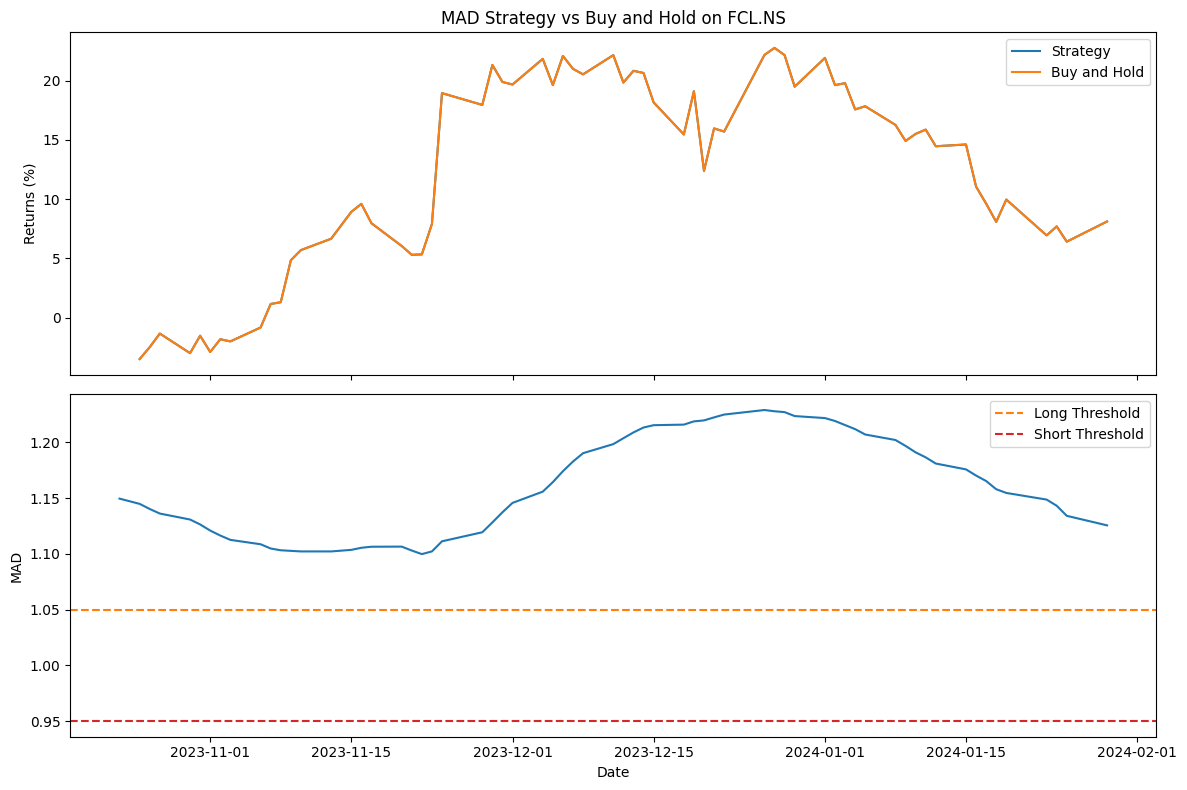

,tot_returns,annual_returns,annual_volatility,sortino_ratio,sharpe_ratio,max_drawdown,max_drawdown_duration
Buy and Hold,0.0812,0.3599,0.3599,1.847,0.9444,0.1332,33
MAD,0.0812,0.3599,0.3599,1.847,0.9444,0.1332,33


In [15]:
strat1 = data.copy()
strat1.dropna(inplace=True)
strat1["position"] = MADSignals(strat1["MAD"], long_level=1.05)
strat1 = calcReturns(strat1)

# Plot results
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
fig, ax = plt.subplots(2, figsize=(12, 8), sharex=True)
ax[0].plot(strat1["strat_cum_returns"] * 100, label="Strategy")
ax[0].plot(strat1["cum_returns"] * 100, label="Buy and Hold")
ax[0].legend()
ax[0].set_ylabel("Returns (%)")
ax[0].set_title(f"MAD Strategy vs Buy and Hold on {ticker}")

ax[1].plot(strat1["MAD"])
ax[1].axhline(1.05, label="Long Threshold", linestyle="--",
              c=colors[1])
ax[1].axhline(0.95, label="Short Threshold", linestyle="--",
              c=colors[3])
ax[1].legend()
ax[1].set_ylabel("MAD")
ax[1].set_xlabel("Date")
plt.tight_layout()
plt.show()

stats = {"Buy and Hold": getStratStats(strat1["log_returns"])}
stats["MAD"] = getStratStats(strat1["strat_log_returns"])
pd.DataFrame.from_dict(stats, orient="index")